This tutorial is designed for one to explore the features of this denoising project. I am using Fastai library, which is built on top of PyTorch. There are several advantages to using Fastai. Ease of use, visualization of whether it be training and valid losses, graphs and images. You could technically run the code from a terminal and still be able to view the graphs and images via terminal. However, I am still in the process of figuring that out and Jupyter notebook will serve as another option until then.

The entire tutorial is broken down into following sections:
#### 1. Importing all the necessary libararies
#### 2. Converting the .nii.gz (nifti images of MRI) into two slices of tiff images
#### 3. Creating the Image Databunch 
#### 4. Creating the model (there are two options)
#### 5. Training and saving the model
#### 6. Inferencing using the save model



## Importing all the modules required..

In [3]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU E5-2686 v4 @ 2.30GHz
stepping	: 1
microcode	: 0xb000038
cpu MHz		: 2699.714
cache size	: 46080 KB
physical id	: 0
siblings	: 4
core id		: 0
cpu cores	: 2
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc aperfmperf pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single kaiser fsgsbase bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx xsaveopt
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4600.18
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	: 

In [12]:
%cd pytorch-msssim

/content/pytorch-msssim


In [13]:
!python setup.py install

running install
running build
running build_py
creating build
creating build/lib
creating build/lib/pytorch_msssim
copying pytorch_msssim/__init__.py -> build/lib/pytorch_msssim
running install_lib
creating /usr/local/lib/python3.6/dist-packages/pytorch_msssim
copying build/lib/pytorch_msssim/__init__.py -> /usr/local/lib/python3.6/dist-packages/pytorch_msssim
byte-compiling /usr/local/lib/python3.6/dist-packages/pytorch_msssim/__init__.py to __init__.cpython-36.pyc
running install_egg_info
Writing /usr/local/lib/python3.6/dist-packages/pytorch_msssim-0.1.egg-info


In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = '3'
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *
from torchvision.models import vgg16_bn
import pdb

gdrive	pytorch-ssim  sample_data


In [2]:
from glob import glob

import sys
from PIL import Image
import nibabel as nib


## Link Google drive for accessing the files and models

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/data/processed"
# root_dir = '/gpfs/fs0/users/kashyap/Research/mriDenoise-convertingFiles2Tiff/data/processed'
# target = root_dir + 'target/'
# train = root_dir + 'train/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Converting Niftii Images to Tiff Files

In [0]:
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

In [0]:
# -- 
def conv_niftti_2_tif(source,dest,axis,startVol,endVolume):
    source = source
    startVolume = startVol
    endVolume = endVolume
    axis = axis #options are 0, 1 or 2
    fnames = glob(os.path.join(source, '*.nii*')) #get the list of niftii files in the source

    ensure_dir(dest)

    for fn in fnames:
        im = nib.load(fn).get_data()
        startIdx = int(startVolume * im.shape[axis])
        endIdx = int(endVolume * im.shape[axis]) + 1
        for i in range(startIdx, endIdx):
            if axis == 0:
                imdata_for_tiff = Image.fromarray(im[i,:,:])
            elif axis == 1:
                imdata_for_tiff = Image.fromarray(im[:,i,:])
            else:
                imdata_for_tiff = Image.fromarray(im[:,:,i])
                fname = os.path.join(dest , f"_{i}.tif")
            print(fname)
            imdata_for_tiff.save(fname)

In [0]:
# conv_niftti_2_tif(source,dest,0,0.2,0.8)

## Testing the type of data that tiff images have

In [0]:
# -- 
# fn = "/content/gdrive/My Drive/results/_100.tif"
# #im = faiv.Image(torch.Tensor(np.asarray(Image.open(fn),dtype=np.float32)[None,...]))

# test_im = Image.open(fn)
# pixData = np.asarray(test_im)
# pixData.dtype
# pixData[0,1]

## Defining new class for reading Tiff images

In [3]:
import fastai.vision as faiv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch import nn
import torchvision


def open_tiff(fn:str) -> faiv.Image:
    """ Return fastai `Image` object created from NIfTI image in file `fn`."""
    return faiv.Image(torch.Tensor(np.asarray(Image.open(fn),dtype=np.float32)[None,...]))

    
class TiffItemList(faiv.ImageList):
    """ custom item list for nifti files """
    def open(self, fn:faiv.PathOrStr)->faiv.Image: return open_tiff(fn)

    
class TiffTiffList(TiffItemList):
    """ item list suitable for synthesis tasks """
    _label_cls = TiffItemList

In [6]:
!pwd

/home/ubuntu/mriDenoise/src


## Testing the TIFFImageList class

In [4]:
from pathlib import Path
"""
path_to_groundtruth = Path('/content/gdrive/My Drive/results')
path_to_training_data = Path('/content/gdrive/My Drive/train')
"""

# path_to_groundtruth = Path(os.path.join(root_dir, 'target'))#'/content/gdrive/My Drive/data/target')
# path_to_training_data = Path(os.path.join(root_dir, 'train'))#'/content/gdrive/My Drive/data/train')
path_to_groundtruth = Path('/home/ubuntu/mriDenoise/data/processed/target')
path_to_training_data = Path('/home/ubuntu/mriDenoise/data/processed/train')
print(path_to_groundtruth)

/home/ubuntu/mriDenoise/data/processed/target


In [5]:
src = TiffTiffList.from_folder(path_to_training_data).split_by_rand_pct(0.1, seed=42)

In [6]:
def get_y_fn(x):
    parent = 'train' if 'train' in str(x) else 'valid'
    fname = x.name.split('.')[0] + "_target.tif"
    #fn = path_to_groundtruth/x.name
    fn = path_to_groundtruth/fname
#     print(fn)
    #pdb.set_trace()
    #print(fn)
    #fn = data_dir/'flair'/parent/f'{str(x.stem)[:10]}-FLAIR_reg_zscore.nii.gz'
    return fn

In [7]:
# def get_data(bs):
# #     data = (src.label_from_func(lambda x: path_to_groundtruth/x.name)
# #            .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
#     data = (src.label_from_func(lambda x: path_to_groundtruth/x.name)
#            .databunch(bs=bs))
#     data.c = 1
#     return data

In [8]:

tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)
new_tfms = (tfms[0][0:5],tfms[1])

In [9]:
new_tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.4, 0.4)}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-20, 20)}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.3), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)])

In [0]:
# data = (src.label_from_func(get_y_fn))
# data.transform(tfms)

In [8]:
import pdb
bs = 32
#pdb.set_trace()
# .transform(tfms,tfm_y=True)
data = (src.label_from_func(get_y_fn)
        .transform(new_tfms,size=45, resize_method=ResizeMethod.SQUISH,tfm_y=True)
        .databunch(bs=bs)).normalize(do_y=True)

data.c = 1

In [9]:
data.batch_stats

<bound method ImageDataBunch.batch_stats of ImageDataBunch;

Train: LabelList (590 items)
x: TiffTiffList
Image (1, 45, 45),Image (1, 45, 45),Image (1, 45, 45),Image (1, 45, 45),Image (1, 45, 45)
y: TiffItemList
Image (1, 45, 45),Image (1, 45, 45),Image (1, 45, 45),Image (1, 45, 45),Image (1, 45, 45)
Path: /home/ubuntu/mriDenoise/data/processed/train;

Valid: LabelList (65 items)
x: TiffTiffList
Image (1, 45, 45),Image (1, 45, 45),Image (1, 45, 45),Image (1, 45, 45),Image (1, 45, 45)
y: TiffItemList
Image (1, 45, 45),Image (1, 45, 45),Image (1, 45, 45),Image (1, 45, 45),Image (1, 45, 45)
Path: /home/ubuntu/mriDenoise/data/processed/train;

Test: None>

In [10]:
x,y = data.train_ds[90]
print(x.shape)
print(y.shape)
x.data

torch.Size([1, 45, 45])
torch.Size([1, 45, 45])


tensor([[[ 984.7350,  973.6959, 1058.3361,  ...,  323.5555,  652.3859,
           511.3673],
         [1016.6434, 1163.4941, 1111.3727,  ...,  527.4813,  421.6649,
           210.4133],
         [ 380.8936,  383.3704,  374.3252,  ...,  116.1554,  447.6964,
           516.5739],
         ...,
         [ 187.8758,  319.1057,  356.5949,  ...,   79.1629,  115.3953,
            84.0244],
         [ 223.9160,  448.1368,  446.3795,  ...,   83.7687,   82.0052,
            93.0229],
         [ 255.1878,  490.6572,  418.9851,  ...,  153.2026,   90.7418,
            87.1791]]])

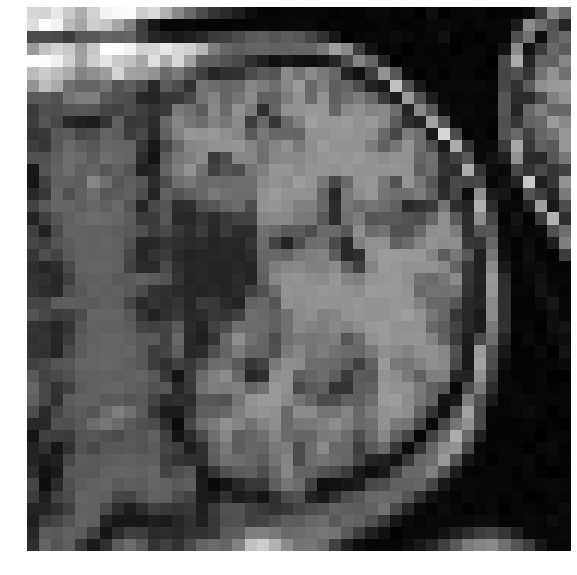

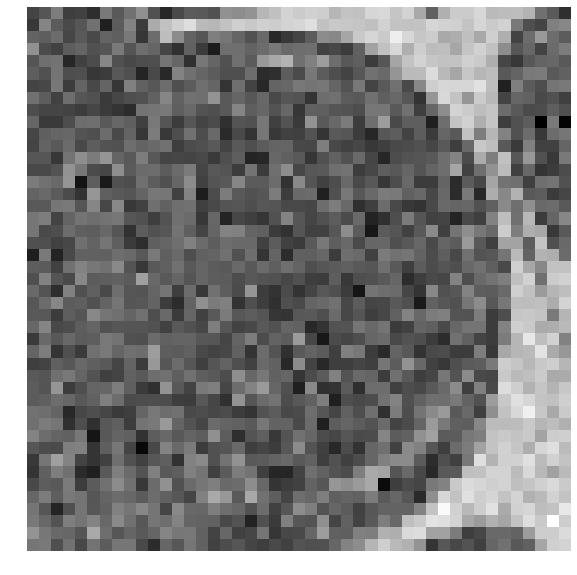

In [11]:
x.show(cmap='gray', figsize=(10,10));
y.show(cmap='gray', figsize=(10,10)); 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1 torch.Size([32, 1, 45, 45]) torch.Size([32, 1, 45, 45]) <class 'fastai.vision.image.Image'> <class 'fastai.vision.image.Image'>
torch.Size([1, 45, 45])


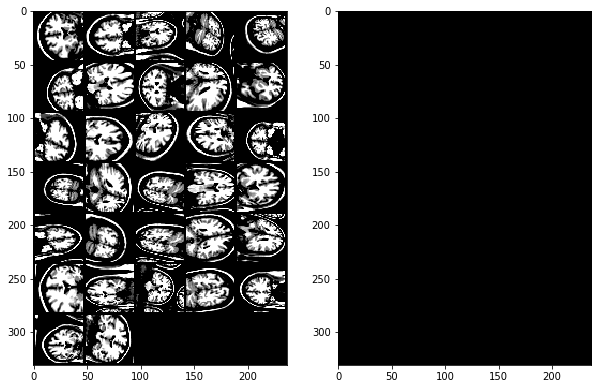

In [13]:
from torchvision.utils import make_grid 
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
# plt.rcParams['figure.figsize'] = [10, 10]
# x_batch, y_batch = data.one_batch()
x_batch,y_batch = next(iter(data.train_dl))

print(x_batch[0].shape[0], x_batch.shape, y_batch.shape, type(x), type(y))
print(x_batch[0].shape)
plt.subplot(1,2,1)
grid_img = torchvision.utils.make_grid(x_batch, nrow=5)
plt.imshow(grid_img.permute(1, 2, 0))
plt.subplot(1,2,2)
grid_img2 = torchvision.utils.make_grid(y_batch, nrow=5)
plt.imshow(grid_img2.permute(1, 2, 0))

In [14]:
print(torch.min(x_batch), torch.max(x_batch))
print(torch.min(y_batch), torch.max(y_batch))

tensor(-1.6671, device='cuda:0') tensor(3.4409, device='cuda:0')
tensor(-1.9077, device='cuda:0') tensor(-1.2224, device='cuda:0')


In [15]:
src, x.data.mean(), x.data.std(), y.data.mean(), y.data.std()

(LabelLists;
 
 Train: LabelList (590 items)
 x: TiffTiffList
 Image (1, 45, 45),Image (1, 45, 45),Image (1, 45, 45),Image (1, 45, 45),Image (1, 45, 45)
 y: TiffItemList
 Image (1, 45, 45),Image (1, 45, 45),Image (1, 45, 45),Image (1, 45, 45),Image (1, 45, 45)
 Path: /home/ubuntu/mriDenoise/data/processed/train;
 
 Valid: LabelList (65 items)
 x: TiffTiffList
 Image (1, 45, 45),Image (1, 45, 45),Image (1, 45, 45),Image (1, 45, 45),Image (1, 45, 45)
 y: TiffItemList
 Image (1, 45, 45),Image (1, 45, 45),Image (1, 45, 45),Image (1, 45, 45),Image (1, 45, 45)
 Path: /home/ubuntu/mriDenoise/data/processed/train;
 
 Test: None,
 tensor(403.7610),
 tensor(219.9018),
 tensor(16.9046),
 tensor(29.5539))

## Simple version of the Model without the ResBlocks

In [10]:
class DnCNN(nn.Module):
    def __init__(self, depth=17, n_channels=64, image_channels=1, use_bnorm=True, kernel_size=3):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        layers = []

        layers.append(nn.Conv2d(in_channels=image_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=True))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(depth-2):
            # TODO: Change each of these into a resnet block instead.
            layers.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(n_channels, eps=0.0001, momentum = 0.95))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=n_channels, out_channels=image_channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)
        

    def forward(self, x):
        y = x
        out = self.dncnn(x)
        return y-out

In [11]:
depth = 17
model = DnCNN(depth=depth)

In [0]:
learn = Learner(data,model.cuda(),metrics=mse,callback_fns=[ShowGraph])
#learn.metrics=[error_rate]
learn.loss_func = MSELossFlat()
learn.summary()

DnCNN
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 45, 45]         640        True      
______________________________________________________________________
ReLU                 [64, 45, 45]         0          False     
______________________________________________________________________
Conv2d               [64, 45, 45]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 45, 45]         128        True      
______________________________________________________________________
ReLU                 [64, 45, 45]         0          False     
______________________________________________________________________
Conv2d               [64, 45, 45]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 45, 45]         128        True      
________________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


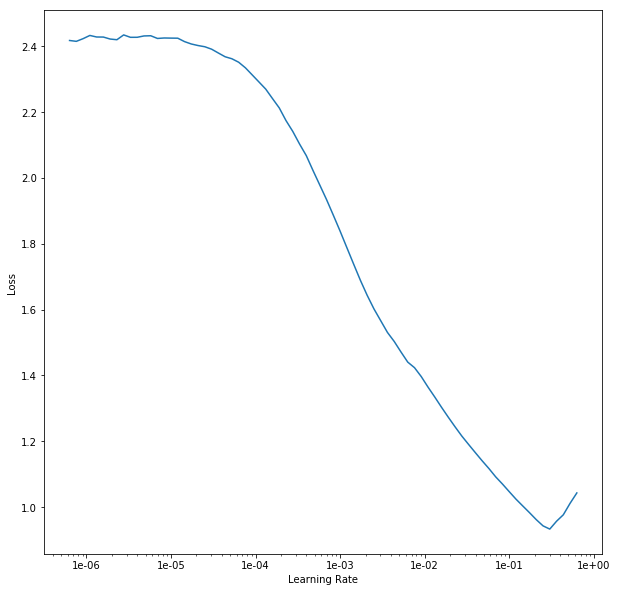

In [0]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,mean_squared_error,time
0,3.275286,2.503392,2.503392,02:40
1,2.425865,1.007691,1.007691,00:09
2,1.525748,0.176450,0.176450,00:05
3,0.972338,0.096854,0.096854,00:05
4,0.648971,0.075351,0.075351,00:05
5,0.446043,0.045853,0.045853,00:06
6,0.312604,0.039310,0.039310,00:06
7,0.222340,0.024532,0.024532,00:06
8,0.162139,0.030713,0.030713,00:06
9,0.119480,0.019964,0.019964,00:05


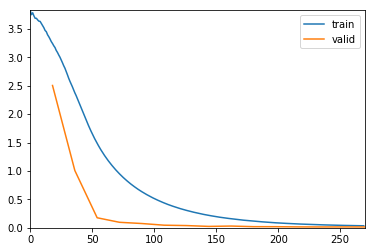

Better model found at epoch 0 with mean_squared_error value: 2.503391981124878.
Better model found at epoch 1 with mean_squared_error value: 1.0076907873153687.
Better model found at epoch 2 with mean_squared_error value: 0.17644986510276794.
Better model found at epoch 3 with mean_squared_error value: 0.09685362130403519.
Better model found at epoch 4 with mean_squared_error value: 0.07535075396299362.
Better model found at epoch 5 with mean_squared_error value: 0.04585285857319832.
Better model found at epoch 6 with mean_squared_error value: 0.03931000828742981.
Better model found at epoch 7 with mean_squared_error value: 0.024532189592719078.
Better model found at epoch 9 with mean_squared_error value: 0.019964443519711494.
Better model found at epoch 10 with mean_squared_error value: 0.019472504034638405.
Better model found at epoch 11 with mean_squared_error value: 0.01598062738776207.
Better model found at epoch 12 with mean_squared_error value: 0.014690473675727844.


In [0]:
num_epochs = 15 
learn.fit_one_cycle(num_epochs,max_lr=1e-3,wd=1e-3,callbacks = [callbacks.SaveModelCallback(learn, mode='min',every='improvement', monitor='mean_squared_error', name='best')])

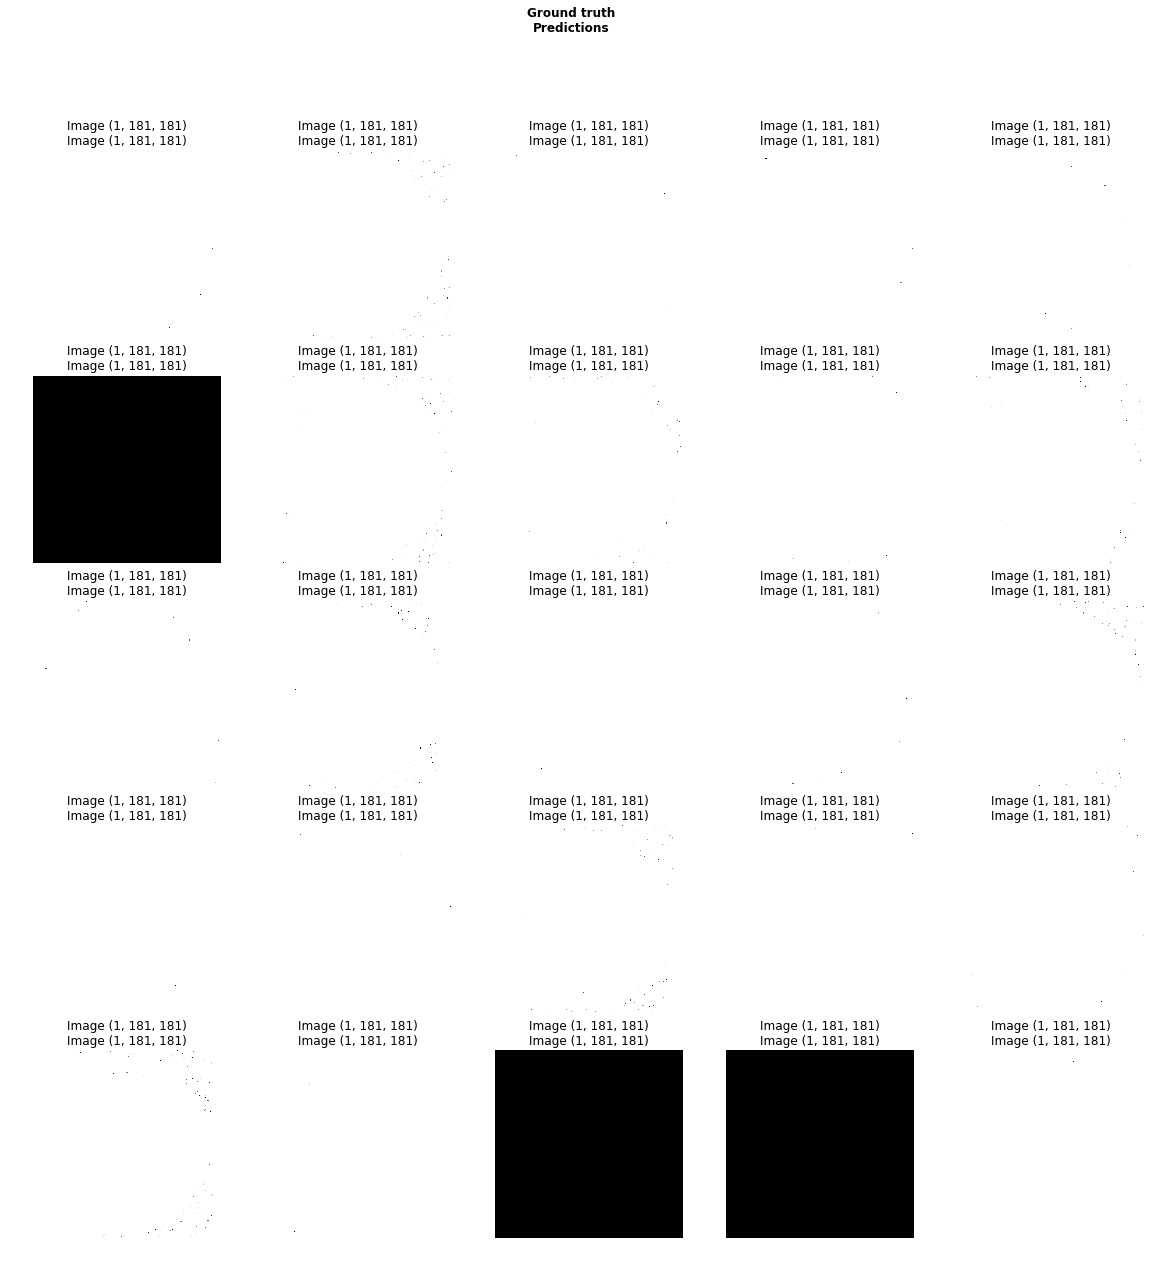

In [0]:
learn.show_results(cmap='gray') #figsize=(10,10))

In [0]:
learn.save('15epochs_sz45_lr1e-3_09292019')

In [0]:
learn.load('15epochs_sz45_lr1e-3_09292019')

## resizing to 90 pixels

In [0]:
import pdb
bs = 32
#pdb.set_trace()
# .transform(tfms,tfm_y=True)
data = (src.label_from_func(get_y_fn)
        .transform(new_tfms,size=90, resize_method=ResizeMethod.SQUISH,tfm_y=True)
        .databunch(bs=bs)).normalize(do_y=True)

data.c = 1

In [0]:
learn = Learner(data,model.cuda(),metrics=mse,callback_fns=[ShowGraph])
#learn.metrics=[error_rate]
learn.loss_func = MSELossFlat()
#learn.summary()

In [0]:
learn.load('15epochs_sz45_lr1e-3_09292019')

Learner(data=ImageDataBunch;

Train: LabelList (590 items)
x: TiffTiffList
Image (1, 90, 90),Image (1, 90, 90),Image (1, 90, 90),Image (1, 90, 90),Image (1, 90, 90)
y: TiffItemList
Image (1, 90, 90),Image (1, 90, 90),Image (1, 90, 90),Image (1, 90, 90),Image (1, 90, 90)
Path: /content/gdrive/My Drive/data/train;

Valid: LabelList (65 items)
x: TiffTiffList
Image (1, 90, 90),Image (1, 90, 90),Image (1, 90, 90),Image (1, 90, 90),Image (1, 90, 90)
y: TiffItemList
Image (1, 90, 90),Image (1, 90, 90),Image (1, 90, 90),Image (1, 90, 90),Image (1, 90, 90)
Path: /content/gdrive/My Drive/data/train;

Test: None, model=DnCNN(
  (dncnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=0.0001, momentum=0.95, affine=True, track_running_stats=True)
    (4): ReLU(inplace)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


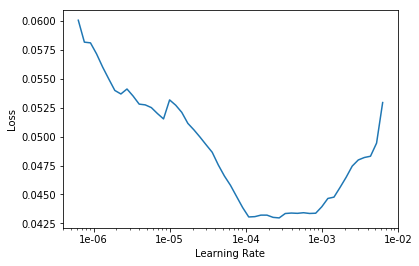

In [0]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,mean_squared_error,time
0,0.050325,0.049113,0.049113,00:11
1,0.044945,0.022201,0.022201,00:11
2,0.036238,0.012231,0.012231,00:11
3,0.028022,0.014080,0.014080,00:11
4,0.023707,0.014512,0.014512,00:11
5,0.020027,0.008829,0.008829,00:11
6,0.017043,0.008766,0.008766,00:11
7,0.015576,0.014278,0.014278,00:11
8,0.013904,0.008874,0.008874,00:11
9,0.012634,0.010576,0.010576,00:11


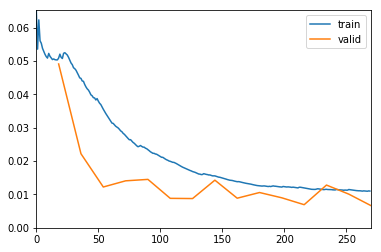

Better model found at epoch 0 with mean_squared_error value: 0.049113381654024124.
Better model found at epoch 1 with mean_squared_error value: 0.0222009290009737.
Better model found at epoch 2 with mean_squared_error value: 0.012231381610035896.
Better model found at epoch 5 with mean_squared_error value: 0.008829116821289062.
Better model found at epoch 6 with mean_squared_error value: 0.008766038343310356.
Better model found at epoch 11 with mean_squared_error value: 0.0069274744018912315.
Better model found at epoch 14 with mean_squared_error value: 0.006622846703976393.


In [0]:
num_epochs = 15 
learn.fit_one_cycle(num_epochs,max_lr=3e-5,wd=1e-3,callbacks = [callbacks.SaveModelCallback(learn, mode='min',every='improvement', monitor='mean_squared_error', name='best')])

In [0]:
learn.save('15epochs_sz90_lr3e-5_09292019')

In [0]:

#learn.destroy()

size = 181

#free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=32
else:           bs=16
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=32, have 9093MB of GPU RAM free


In [12]:
import pdb
bs = 32
#pdb.set_trace()
# .transform(tfms,tfm_y=True)
data = (src.label_from_func(get_y_fn)
        .transform(new_tfms,size=181, resize_method=ResizeMethod.SQUISH,tfm_y=True)
        .databunch(bs=bs)).normalize(do_y=True)

data.c = 1

In [13]:
learn = Learner(data,model.cuda(),metrics=mse,callback_fns=[ShowGraph])
#learn.metrics=[error_rate]
learn.loss_func = MSELossFlat()
#learn.summary()

In [0]:
learn.load('15epochs_sz90_lr3e-5_09292019')

Learner(data=ImageDataBunch;

Train: LabelList (590 items)
x: TiffTiffList
Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181)
y: TiffItemList
Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181)
Path: /content/gdrive/My Drive/data/train;

Valid: LabelList (65 items)
x: TiffTiffList
Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181)
y: TiffItemList
Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181)
Path: /content/gdrive/My Drive/data/train;

Test: None, model=DnCNN(
  (dncnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=0.0001, momentum=0.95, affine=True, track_running_stats=True)
    (4): ReLU(inplace)
    (5): Conv2d

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


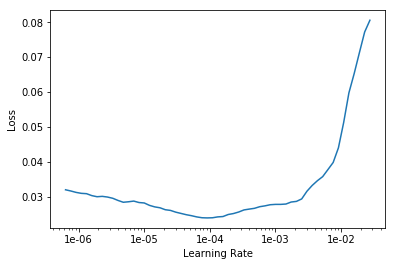

In [0]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,mean_squared_error,time
0,0.029935,0.037184,0.037184,01:16
1,0.025841,0.023358,0.023358,01:16
2,0.021057,0.020178,0.020178,01:16
3,0.017354,0.014465,0.014465,01:16
4,0.014759,0.010688,0.010688,01:16
5,0.012623,0.008717,0.008717,01:16
6,0.011020,0.009958,0.009958,01:16
7,0.010317,0.008962,0.008962,01:16
8,0.009648,0.008805,0.008805,01:16
9,0.009533,0.012725,0.012725,01:16


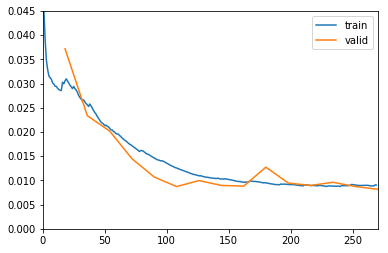

Better model found at epoch 0 with mean_squared_error value: 0.03718426078557968.
Better model found at epoch 1 with mean_squared_error value: 0.023357510566711426.
Better model found at epoch 2 with mean_squared_error value: 0.020178351551294327.
Better model found at epoch 3 with mean_squared_error value: 0.014465353451669216.
Better model found at epoch 4 with mean_squared_error value: 0.010687708854675293.
Better model found at epoch 5 with mean_squared_error value: 0.008717390708625317.
Better model found at epoch 14 with mean_squared_error value: 0.008161659352481365.


In [0]:
num_epochs = 15 
learn.fit_one_cycle(num_epochs,max_lr=1e-5,wd=1e-3,callbacks = [callbacks.SaveModelCallback(learn, mode='min',every='improvement', monitor='mean_squared_error', name='best')])

ImageDataBunch;

Train: LabelList (590 items)
x: TiffTiffList
Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181)
y: TiffItemList
Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181)
Path: /content/gdrive/My Drive/data/train;

Valid: LabelList (65 items)
x: TiffTiffList
Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181)
y: TiffItemList
Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181)
Path: /content/gdrive/My Drive/data/train;

Test: None

In [17]:
# im = os.path.join(root_dir, "train","t1_icbm_normal_1mm_pn3_rf0_50.tif" )#"/content/gdrive/My Drive/data/train/t1_icbm_normal_1mm_pn3_rf0_50.tif"
im = "/home/ubuntu/mriDenoise/data/processed/train/t1_icbm_normal_1mm_pn9_rf0_50_target.tif"

In [18]:
im1 = open_tiff(im)
im1.show(cmap='gray', figsize=(10,10))

FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/mriDenoise/data/processed/train/t1_icbm_normal_1mm_pn9_rf0_50_target.tif'

In [0]:
a = learn.predict(im1)

In [0]:
print(len(a), a[0].shape, a[1].shape, a[2].shape, type(a[0]), type(a[1]), type(a[2]))

3 torch.Size([1, 181, 181]) torch.Size([1, 181, 181]) torch.Size([1, 181, 181]) <class 'fastai.vision.image.Image'> <class 'torch.Tensor'> <class 'torch.Tensor'>


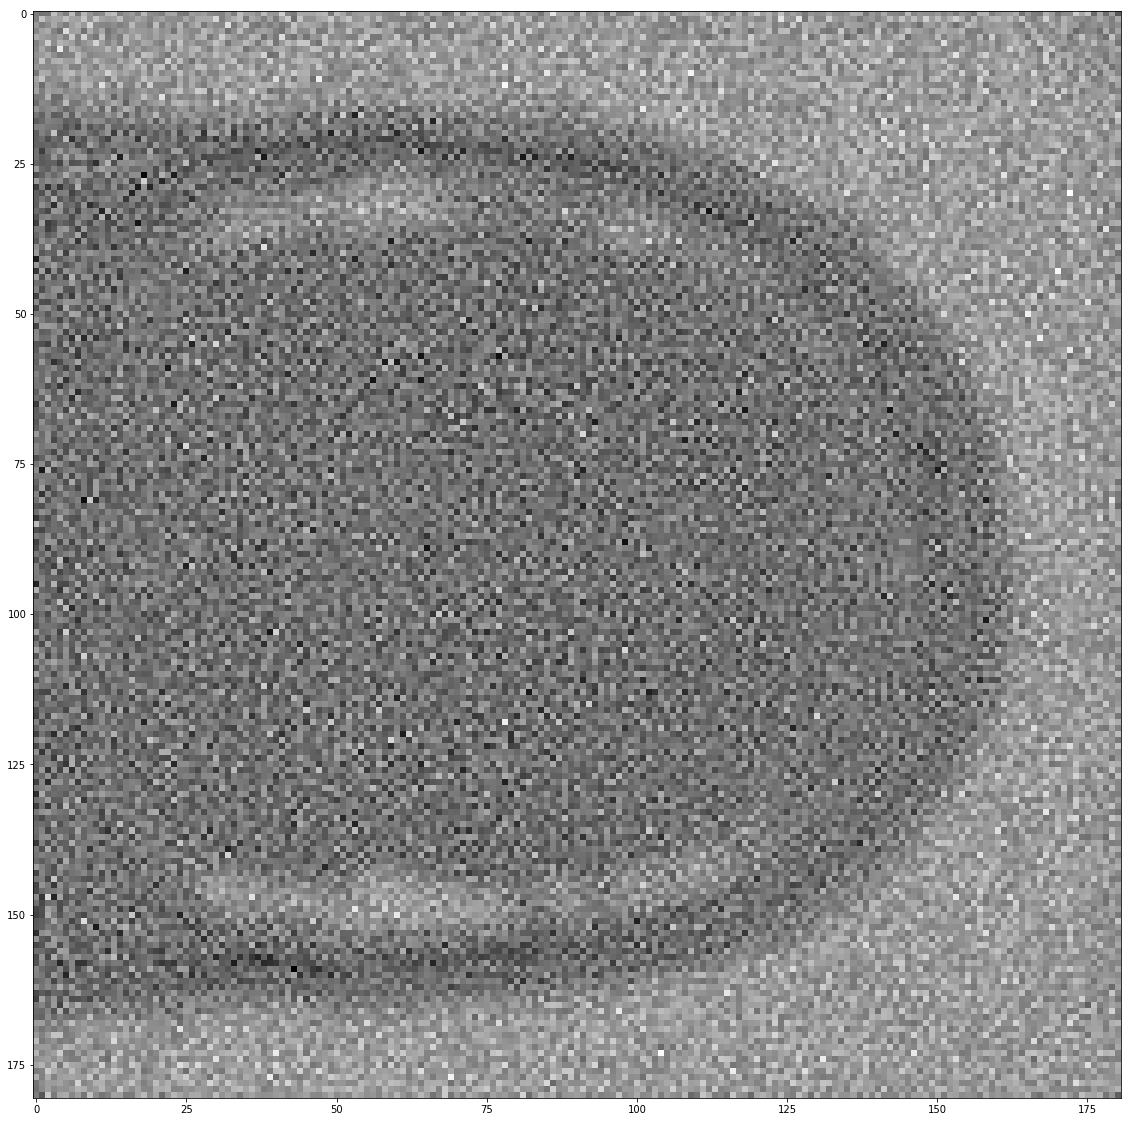

In [0]:
plt.imshow(faiv.image2np(a[1]), cmap='gray')

In [0]:
print(torch.max(im1.data), torch.min(im1.data), torch.max(a[2]), torch.min(a[2]), torch.max(a[1]), torch.min(a[1]))
out = im1.data - a[2]
torch.min(out), torch.max(out)

tensor(1255.3278) tensor(0.1716) tensor(224.5881) tensor(-170.0652) tensor(224.5881) tensor(-170.0652)


(tensor(-19.7723), tensor(1181.4872))

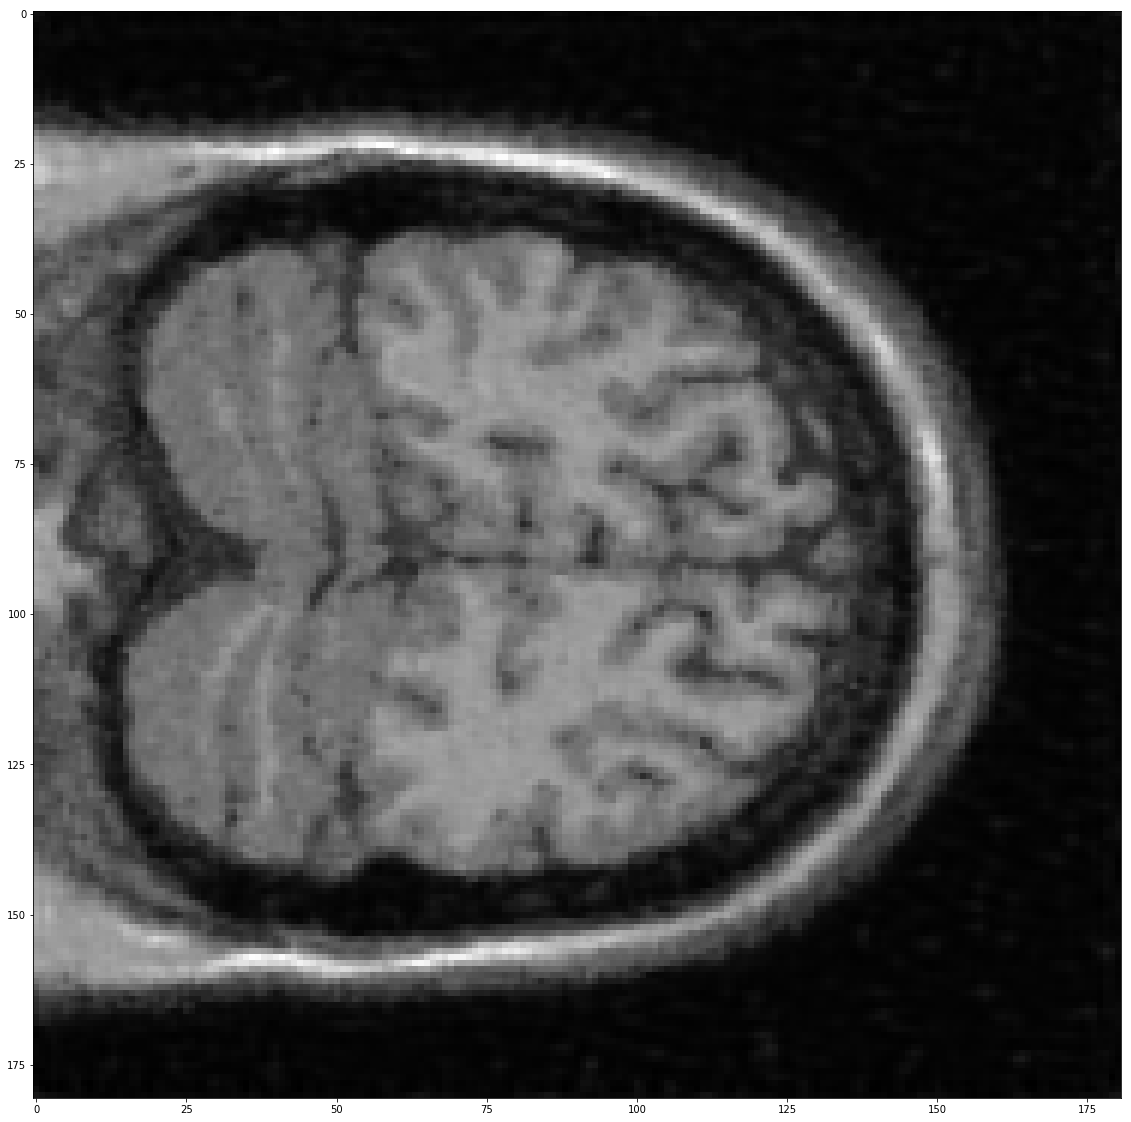

In [0]:
plt.imshow(faiv.image2np(out), cmap='gray')

In [0]:
data.classes

In [0]:
a[0].show();im1.show();default.cmap='binary'

In [0]:
learn.fit_one_cycle(50,max_lr=1e-3,callbacks = [callbacks.SaveModelCallback(learn, every='improvement', monitor='mean_squared_error', name='best')])

In [0]:
learn.save("after_100_epochs_1e-3")

In [0]:
learn.fit_one_cycle(30,max_lr=1e-4,callbacks = [callbacks.SaveModelCallback(learn, every='improvement', monitor='mean_squared_error', name='best')])

In [0]:
learn.save("30_epocs_after_prv_100_lr1e-4")

In [0]:
learn.load("30_epocs_after_prv_100_lr1e-4")

In [0]:
learn.fit_one_cycle(70,max_lr=1e-4,callbacks = [callbacks.SaveModelCallback(learn, every='improvement', monitor='mean_squared_error', name='best')])
learn.save("70_epocs_after_prv_30_lr1e-4")

In [0]:
learn.recorder.plot()

In [0]:
learn.save('after_30_epocs_simple_DCNN')

In [0]:
learn.load('after_30_epocs_simple_DCNN')

In [0]:
learn.fit_one_cycle(50,max_lr=1e-4,callbacks = [callbacks.SaveModelCallback(learn, every='improvement', monitor='mean_squared_error', name='best')])

In [0]:
x,y = data.train_ds[0]

In [0]:
x.shape

In [0]:
type(y)

In [0]:
tfms = get_transforms()
tfms

## My version of the same DnCNN

In [14]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=1, padding=1)

In [15]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=1)

In [16]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [17]:
class myDnCNN(nn.Module):
    def __init__(self, depth=17, n_channels=64, image_channels=1, use_bnorm=True, kernel_size=3):
        super(myDnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        layers = []
        
        layers.append(conv(ni=image_channels,nf=n_channels))
        layers.append(nn.ReLU())

        for _ in range(depth-2):
            # TODO: Change each of these into a resnet block instead.
            layers.append(conv_and_res(ni=n_channels,nf=n_channels))
            
        layers.append(conv(ni=n_channels,nf=image_channels))
        self.mydncnn = nn.Sequential(*layers)
        

    def forward(self, x):
        y = x
        out = self.mydncnn(x)
        return y-out

In [18]:
depth = 8
mymodel = myDnCNN(depth)

In [20]:
mylearn = Learner(data,mymodel.cuda(),metrics=mse,callback_fns=[ShowGraph])
#learn.metrics=[error_rate]
mylearn.loss_func = MSELossFlat()
#learn.summary()

In [0]:
# mylearn.loss_func = MSELossFlat()

In [15]:
mylearn.summary()

myDnCNN
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 181, 181]       640        True      
______________________________________________________________________
ReLU                 [64, 181, 181]       0          False     
______________________________________________________________________
Conv2d               [64, 181, 181]       36,864     True      
______________________________________________________________________
ReLU                 [64, 181, 181]       0          False     
______________________________________________________________________
BatchNorm2d          [64, 181, 181]       128        True      
______________________________________________________________________
Conv2d               [64, 181, 181]       36,864     True      
______________________________________________________________________
ReLU                 [64, 181, 181]       0          False     
______________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


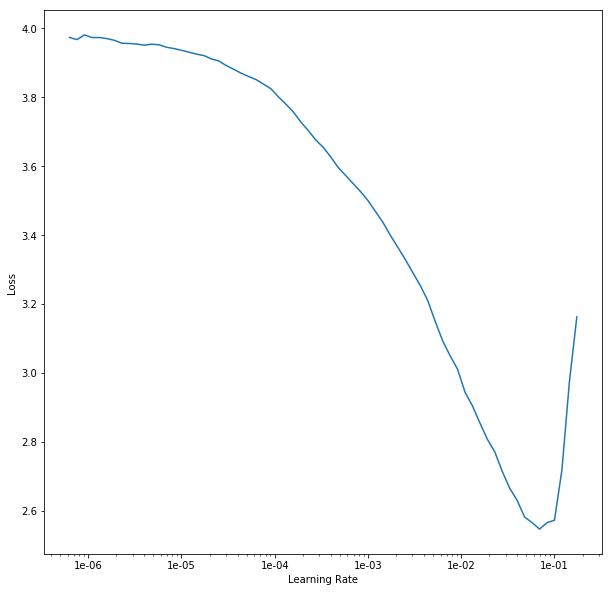

In [23]:
mylearn.lr_find()
mylearn.recorder.plot()

epoch,train_loss,valid_loss,mean_squared_error,time
0,3.257513,1.646233,1.646233,00:04
1,2.772364,1.431962,1.431962,00:04
2,1.974108,0.537194,0.537194,00:04
3,1.243057,0.192788,0.192788,00:04
4,0.815539,0.055537,0.055537,00:04
5,0.551834,0.044853,0.044853,00:04
6,0.381783,0.029675,0.029675,00:04
7,0.269715,0.025909,0.025909,00:04
8,0.193361,0.022395,0.022395,00:04
9,0.141008,0.018618,0.018618,00:04


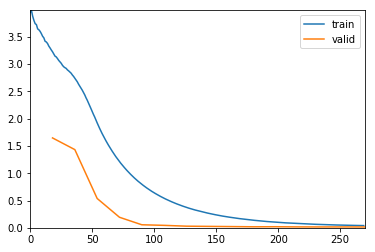

Better model found at epoch 0 with mean_squared_error value: 1.6462327241897583.


In [26]:
mylearn.fit_one_cycle(15,max_lr=2e-3,callbacks = [callbacks.SaveModelCallback(mylearn, every='improvement', monitor='mean_squared_error', name='best')])
mylearn.save("15_epocs_mydnn_lr2e-4_09302019")

## change size to 90 px by 90 px

In [27]:
import pdb
bs = 32
size = 90
#pdb.set_trace()
# .transform(tfms,tfm_y=True)
data = (src.label_from_func(get_y_fn)
        .transform(new_tfms,size=size, resize_method=ResizeMethod.SQUISH,tfm_y=True)
        .databunch(bs=bs)).normalize(do_y=True)

data.c = 1

In [28]:
mylearn.data = data

In [30]:
mylearn.load("15_epocs_mydnn_lr2e-4_09302019")

Learner(data=ImageDataBunch;

Train: LabelList (590 items)
x: TiffTiffList
Image (1, 90, 90),Image (1, 90, 90),Image (1, 90, 90),Image (1, 90, 90),Image (1, 90, 90)
y: TiffItemList
Image (1, 90, 90),Image (1, 90, 90),Image (1, 90, 90),Image (1, 90, 90),Image (1, 90, 90)
Path: /home/ubuntu/mriDenoise/data/processed/train;

Valid: LabelList (65 items)
x: TiffTiffList
Image (1, 90, 90),Image (1, 90, 90),Image (1, 90, 90),Image (1, 90, 90),Image (1, 90, 90)
y: TiffItemList
Image (1, 90, 90),Image (1, 90, 90),Image (1, 90, 90),Image (1, 90, 90),Image (1, 90, 90)
Path: /home/ubuntu/mriDenoise/data/processed/train;

Test: None, model=myDnCNN(
  (mydncnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU(inplace)
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


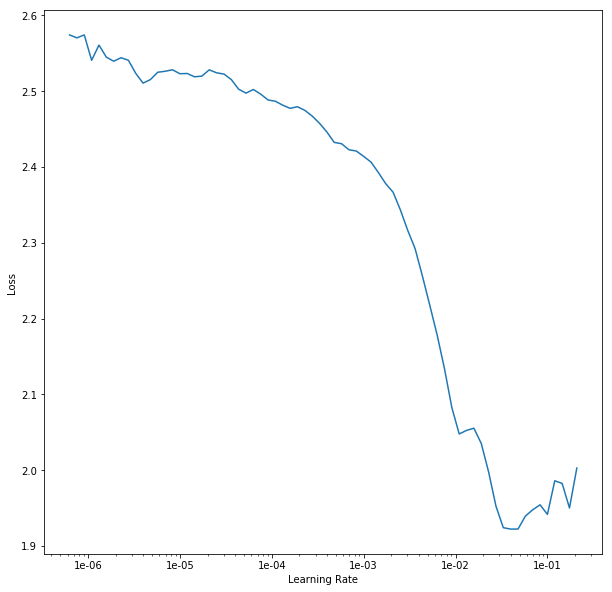

In [31]:
mylearn.lr_find()
mylearn.recorder.plot()

epoch,train_loss,valid_loss,mean_squared_error,time
0,2.311385,2.044426,2.044426,00:12
1,1.917916,0.744704,0.744704,00:12
2,1.198740,0.406411,0.406411,00:12
3,0.753846,0.047677,0.047677,00:12
4,0.493620,0.023394,0.023394,00:12
5,0.334736,0.059902,0.059902,00:12
6,0.235778,0.032020,0.032020,00:12
7,0.168043,0.015422,0.015422,00:12
8,0.121797,0.018590,0.018590,00:12
9,0.089821,0.018831,0.018831,00:12


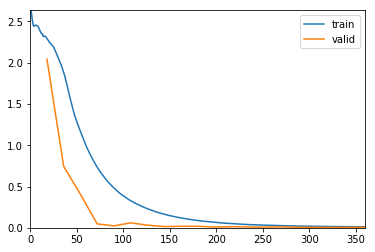

Better model found at epoch 0 with mean_squared_error value: 2.0444259643554688.
Better model found at epoch 1 with mean_squared_error value: 0.7447037696838379.
Better model found at epoch 2 with mean_squared_error value: 0.4064105749130249.
Better model found at epoch 3 with mean_squared_error value: 0.04767680913209915.
Better model found at epoch 4 with mean_squared_error value: 0.023393843322992325.
Better model found at epoch 7 with mean_squared_error value: 0.01542231161147356.
Better model found at epoch 10 with mean_squared_error value: 0.009049528278410435.
Better model found at epoch 13 with mean_squared_error value: 0.007815487682819366.
Better model found at epoch 15 with mean_squared_error value: 0.0064467028714716434.
Better model found at epoch 16 with mean_squared_error value: 0.005428607575595379.
Better model found at epoch 17 with mean_squared_error value: 0.005399791989475489.
Better model found at epoch 19 with mean_squared_error value: 0.005267246626317501.


In [32]:
mylearn.fit_one_cycle(20,max_lr=5e-3,callbacks = [callbacks.SaveModelCallback(mylearn, mode='min',every='improvement', monitor='mean_squared_error', name='best')])
mylearn.save("20_epocs_mydnn_lr5e-3_sz90_09302019")

In [19]:
import pdb
bs = 16
size = 181
#pdb.set_trace()
# .transform(tfms,tfm_y=True)
data = (src.label_from_func(get_y_fn)
        .transform(new_tfms,size=size, resize_method=ResizeMethod.SQUISH,tfm_y=True)
        .databunch(bs=bs)).normalize(do_y=True)

data.c = 1

In [38]:
mylearn.data = data

In [39]:
mylearn.load("20_epocs_mydnn_lr5e-3_sz90_09302019")

Learner(data=ImageDataBunch;

Train: LabelList (590 items)
x: TiffTiffList
Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181)
y: TiffItemList
Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181)
Path: /home/ubuntu/mriDenoise/data/processed/train;

Valid: LabelList (65 items)
x: TiffTiffList
Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181)
y: TiffItemList
Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181)
Path: /home/ubuntu/mriDenoise/data/processed/train;

Test: None, model=myDnCNN(
  (mydncnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU(inplace)
        (2): BatchNorm2d(64, eps=1e-05,

In [41]:
mylearn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


In [57]:
import pdb
bs = 8
size = 181
#pdb.set_trace()
# .transform(tfms,tfm_y=True)
data = (src.label_from_func(get_y_fn)
        .transform(new_tfms,size=size, resize_method=ResizeMethod.SQUISH,tfm_y=True)
        .databunch(bs=bs)).normalize(do_y=True)

data.c = 1

In [58]:
mylearn = Learner(data,mymodel.cuda(),metrics=mse,callback_fns=[ShowGraph])
#learn.metrics=[error_rate]
mylearn.loss_func = MSELossFlat()
#learn.summary()

In [45]:
mylearn.load("20_epocs_mydnn_lr5e-3_sz90_09302019")

Learner(data=ImageDataBunch;

Train: LabelList (590 items)
x: TiffTiffList
Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181)
y: TiffItemList
Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181)
Path: /home/ubuntu/mriDenoise/data/processed/train;

Valid: LabelList (65 items)
x: TiffTiffList
Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181)
y: TiffItemList
Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181)
Path: /home/ubuntu/mriDenoise/data/processed/train;

Test: None, model=myDnCNN(
  (mydncnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU(inplace)
        (2): BatchNorm2d(64, eps=1e-05,

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


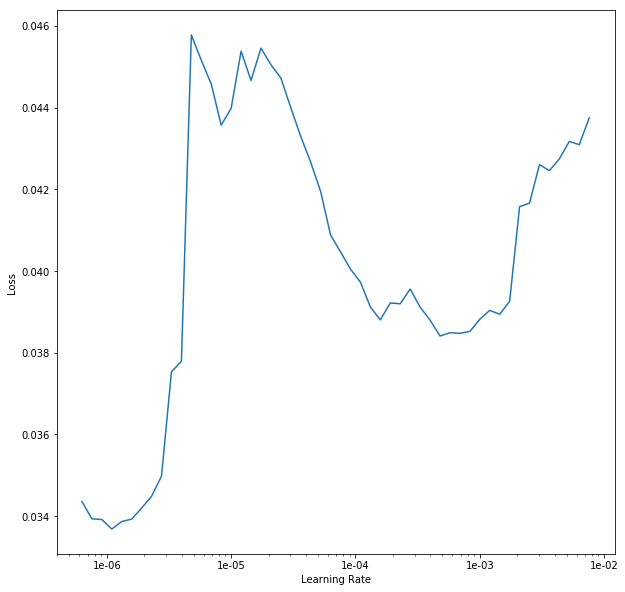

In [46]:
mylearn.lr_find()
mylearn.recorder.plot()

epoch,train_loss,valid_loss,mean_squared_error,time
0,0.033799,0.033803,0.033803,01:56
1,0.025315,0.016945,0.016945,01:55
2,0.017918,0.010700,0.010700,01:55
3,0.016430,0.008872,0.008872,01:55
4,0.015407,0.008170,0.008170,01:55
5,0.013010,0.007798,0.007798,01:55
6,0.014557,0.007169,0.007169,01:55
7,0.014270,0.007085,0.007085,01:55
8,0.012373,0.006935,0.006935,01:55


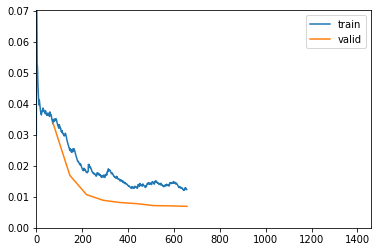

Better model found at epoch 0 with mean_squared_error value: 0.03380294516682625.
Better model found at epoch 1 with mean_squared_error value: 0.016944726929068565.
Better model found at epoch 2 with mean_squared_error value: 0.010700352489948273.
Better model found at epoch 3 with mean_squared_error value: 0.00887240655720234.
Better model found at epoch 4 with mean_squared_error value: 0.008169988170266151.
Better model found at epoch 5 with mean_squared_error value: 0.007797559257596731.
Better model found at epoch 6 with mean_squared_error value: 0.007169228047132492.
Better model found at epoch 7 with mean_squared_error value: 0.007085157558321953.
Better model found at epoch 8 with mean_squared_error value: 0.006935372948646545.


In [ ]:
mylearn.fit_one_cycle(20,max_lr=3e-5,callbacks = [callbacks.SaveModelCallback(mylearn, mode='min',every='improvement', monitor='mean_squared_error', name='best')])
mylearn.save("20_epocs_mydnn_lr3e-5_sz181_09302019")

In [21]:
# mylearn.load("20_epocs_mydnn_lr3e-5_sz181_09302019")
mylearn.load("best")

Learner(data=ImageDataBunch;

Train: LabelList (590 items)
x: TiffTiffList
Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181)
y: TiffItemList
Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181)
Path: /home/ubuntu/mriDenoise/data/processed/train;

Valid: LabelList (65 items)
x: TiffTiffList
Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181)
y: TiffItemList
Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181),Image (1, 181, 181)
Path: /home/ubuntu/mriDenoise/data/processed/train;

Test: None, model=myDnCNN(
  (mydncnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Sequential(
      (0): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU(inplace)
        (2): BatchNorm2d(64, eps=1e-05,

In [22]:
# im = os.path.join(root_dir, "train","t1_icbm_normal_1mm_pn3_rf0_50.tif" )#"/content/gdrive/My Drive/data/train/t1_icbm_normal_1mm_pn3_rf0_50.tif"
im = "/home/ubuntu/mriDenoise/data/processed/train/t1_icbm_normal_1mm_pn9_rf0_50.tif"

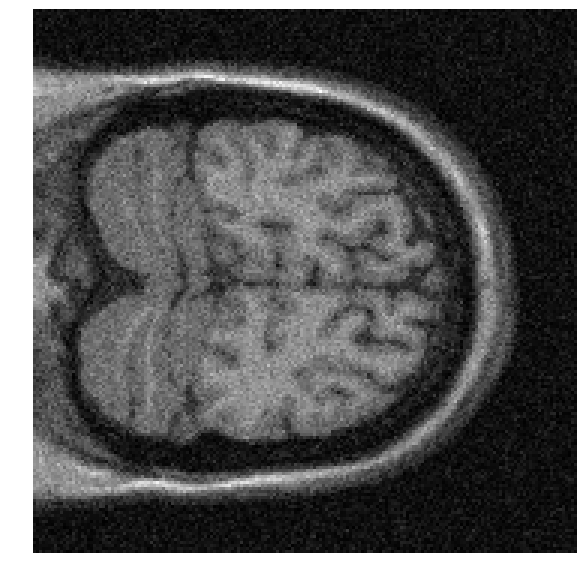

In [23]:
im1 = open_tiff(im)
im1.show(cmap='gray', figsize=(10,10))

In [25]:
%timeit a = mylearn.predict(im1)

51.1 ms ± 182 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [20]:
print(len(a), a[0].shape, a[1].shape, a[2].shape, type(a[0]), type(a[1]), type(a[2]))

3 torch.Size([1, 181, 181]) torch.Size([1, 181, 181]) torch.Size([1, 181, 181]) <class 'fastai.vision.image.Image'> <class 'torch.Tensor'> <class 'torch.Tensor'>


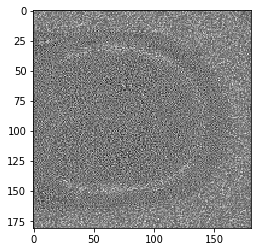

In [21]:
plt.imshow(faiv.image2np(a[1]), cmap='gray')

In [23]:
print(torch.max(im1.data), torch.min(im1.data), torch.max(a[2]), torch.min(a[2]), torch.max(a[1]), torch.min(a[1]))
out = im1.data - a[2]
torch.min(out), torch.max(out)

tensor(1255.3278) tensor(0.1716) tensor(265.3579) tensor(-122.7876) tensor(265.3579) tensor(-122.7876)


(tensor(-64.2594), tensor(1130.1125))

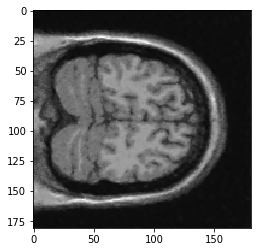

In [24]:
plt.imshow(faiv.image2np(out), cmap='gray')

In [25]:
from skimage.measure import compare_psnr, compare_ssim

In [26]:
def calculate_psnr_ssim(im_target,im_to_test):
  val_range = im_to_test.max() - im_to_test.min()
  psnr = compare_psnr(im_target,im_to_test,data_range=val_range)
  ssim = compare_ssim(im_target,im_to_test,data_range=val_range)
  return psnr,ssim

In [27]:
fn_np = im1.data.view(181,181).numpy()

In [28]:
fn_source = out.view(181,181).numpy()

In [30]:
fn_target = "/home/ubuntu/mriDenoise/data/t1_icbm_normal_1mm_pn9_rf0_50_target.tif"
target_psnr = np.asarray(Image.open(fn_target),dtype=np.float32)

In [31]:
type(target_psnr)

numpy.ndarray

In [33]:
(psnr,ssim) = calculate_psnr_ssim(target_psnr,fn_np)
print(f"the psnr is {psnr}, and the ssim is {ssim}")

the psnr is 24.830027389206755, and the ssim is 0.5627609250663271


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]


In [0]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'small-96'
path_mr = path/'small-256'

In [0]:
path_hr

In [0]:
il = ImageList.from_folder(path_hr)

In [0]:
?il

In [0]:
def resize_one(fn, i, path, size):
    dest = path/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [0]:
# create smaller image sets the first time this nb is run
sets = [(path_lr, 96), (path_mr, 256)]
for p,size in sets:
    if not p.exists(): 
        print(f"resizing to {size} into {p}")
        parallel(partial(resize_one, path=p, size=size), il.items)

In [0]:
bs,size=32,128
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [0]:
src

In [0]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [0]:
data = get_data(bs,size)

In [0]:
data.c

In [0]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

## Feature loss

In [0]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [0]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [0]:
gram_matrix(t)

In [0]:
base_loss = F.l1_loss

In [0]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [0]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

In [0]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [0]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Train

In [0]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-3

In [0]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

In [0]:
do_fit('1a', slice(lr*10))

In [0]:
learn.unfreeze()

In [0]:
do_fit('1b', slice(1e-5,lr))

In [0]:
data = get_data(12,size*2)

In [0]:
learn.data = data
learn.freeze()
gc.collect()

In [0]:
learn.load('1b');

In [0]:
do_fit('2a')

In [0]:
learn.unfreeze()

In [0]:
do_fit('2b', slice(1e-6,1e-4), pct_start=0.3)

## Test

In [0]:
learn = None
gc.collect();

In [0]:
256/320*1024

In [0]:
256/320*1600

In [0]:
free = gpu_mem_get_free_no_cache()
# the max size of the test image depends on the available GPU RAM 
if free > 8000: size=(1280, 1600) # >  8GB RAM
else:           size=( 820, 1024) # <= 8GB RAM
print(f"using size={size}, have {free}MB of GPU RAM free")

In [0]:
learn = unet_learner(data, arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight)

In [0]:
data_mr = (ImageImageList.from_folder(path_mr).split_by_rand_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr/x.name)
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_mr.c = 3

In [0]:
learn.load('2b');

In [0]:
learn.data = data_mr

In [0]:
fn = data_mr.valid_ds.x.items[0]; fn

In [0]:
img = open_image(fn); img.shape

In [0]:
p,img_hr,b = learn.predict(img)

In [0]:
show_image(img, figsize=(18,15), interpolation='nearest');

In [0]:
Image(img_hr).show(figsize=(18,15))